Title: User Modeling System

Introduction

Data modeling is one of the most powerful tools to analyze data and draw meaningful conclusions from it. To score well on a test, it is important that we use a method of study which has historically and scientifically been proven efficient. Is it better to study one night before the exam for an extended period of time or to distribute study sessions in intervals of 30-40 minutes over a couple of days?

 We use the data set “uns_datatable.xls” which consists of students’ educational features such as study time, repetitions, exam performance in current and pre-requisite courses, etc. The goal is to establish a relationship between a student’s educational habits and conceptual understanding. 


Preliminary exploratory data analysis:

Methods:

Expected outcomes and significance:

First, we needed to import all of the libraries required for the research of our project:

In [48]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)

Now we need to read in the required data, and wrangle it into a usable format. To do this, we need to first only read the first six columns, as the later columns are explanations of what the variable are and aren't actual data entries themselves. Also we only wish to use the training data 

In [49]:
knowledge <- read_excel("data/uns_datatable.xls", sheet = "Training_Data", range = cell_cols("A:F"))

To further wrangle our data into a usable format, we wish to convert the last row, with only a limited number of possible options, to a factor.

In [79]:
knowledge <- mutate(knowledge_data_df, UNS = as_factor(UNS))
knowledge

STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.00,0.000,0.00,0.00,0.00,very_low
0.08,0.080,0.10,0.24,0.90,High
0.06,0.060,0.05,0.25,0.33,Low
0.10,0.100,0.15,0.65,0.30,Middle
0.08,0.080,0.08,0.98,0.24,Low
0.09,0.150,0.40,0.10,0.66,Middle
0.10,0.100,0.43,0.29,0.56,Middle
0.15,0.020,0.34,0.40,0.01,very_low
0.20,0.140,0.35,0.72,0.25,Low


Great! Now each column stores a single variable, each row stores a single observation, and each cell stores a single value. This data is tidy. The only other thing we could do is to create a quick legend to make the variable names more understandable, we will simply outline such a legend here, to be easily referred to when more readable names are required by the various visualizations in the later steps of this project.

Variable Legend:

STG (The degree of study time for goal object materials)
SCG (The degree of repetition number of user for goal object materials)
STR (The degree of study time of user for related objects with goal object)
LPR (The exam performance of user for related objects with goal object)
PEG (The exam performance of user for goal objects)
UNS (The knowledge level of user)
     
Within this study, based on our chosen research question, we will actually only require usage of the following variables: the study time for the objective material (STG), the degree of repitition in the studying of said material (SCG), and the knowledge level of the person (UNS).

In [80]:
data summary

ERROR: Error in parse(text = x, srcfile = src): <text>:1:6: unexpected symbol
1: data summary
         ^


In [84]:
# knowledge_data_df %>% 
# group_by(UNS) %>% 
# summarize(n = n())

know_count <- nrow(knowledge)
    knowledge %>%
    group_by(UNS) %>%
    summarize(count = n(),
    percentage = n() / know_count * 100)

`summarise()` ungrouping output (override with `.groups` argument)



UNS,count,percentage
<fct>,<int>,<dbl>
very_low,24,9.302326
High,63,24.418605
Low,83,32.170543
Middle,88,34.108527


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



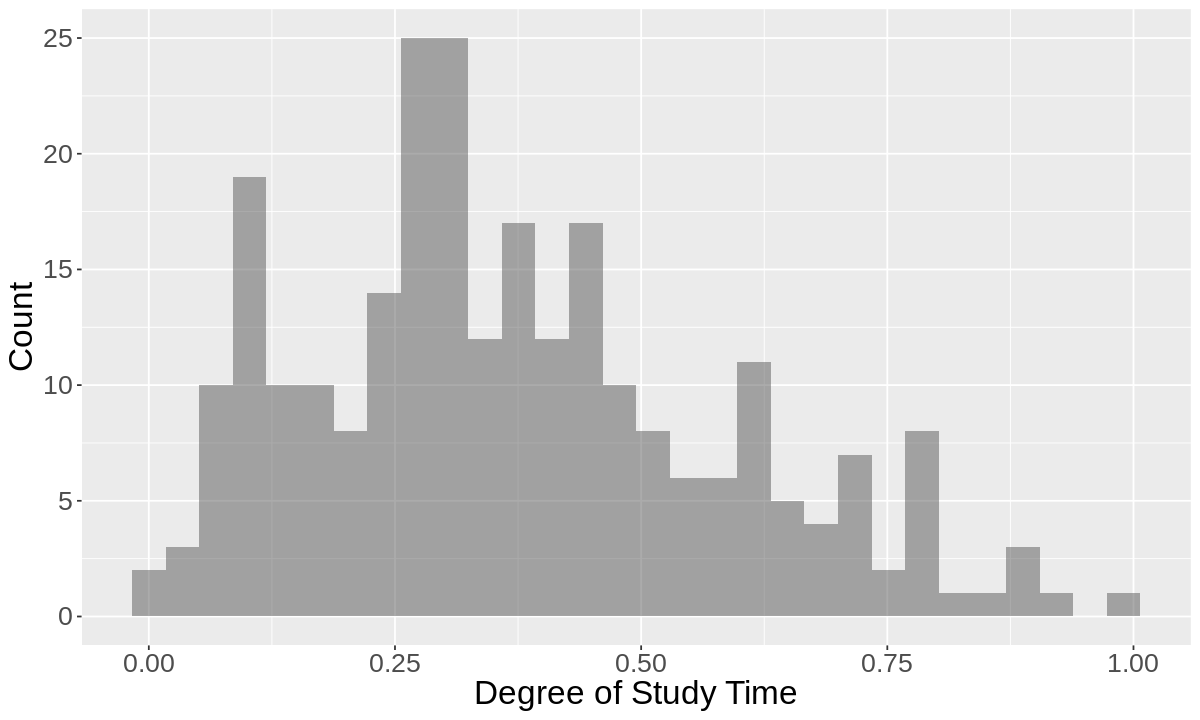

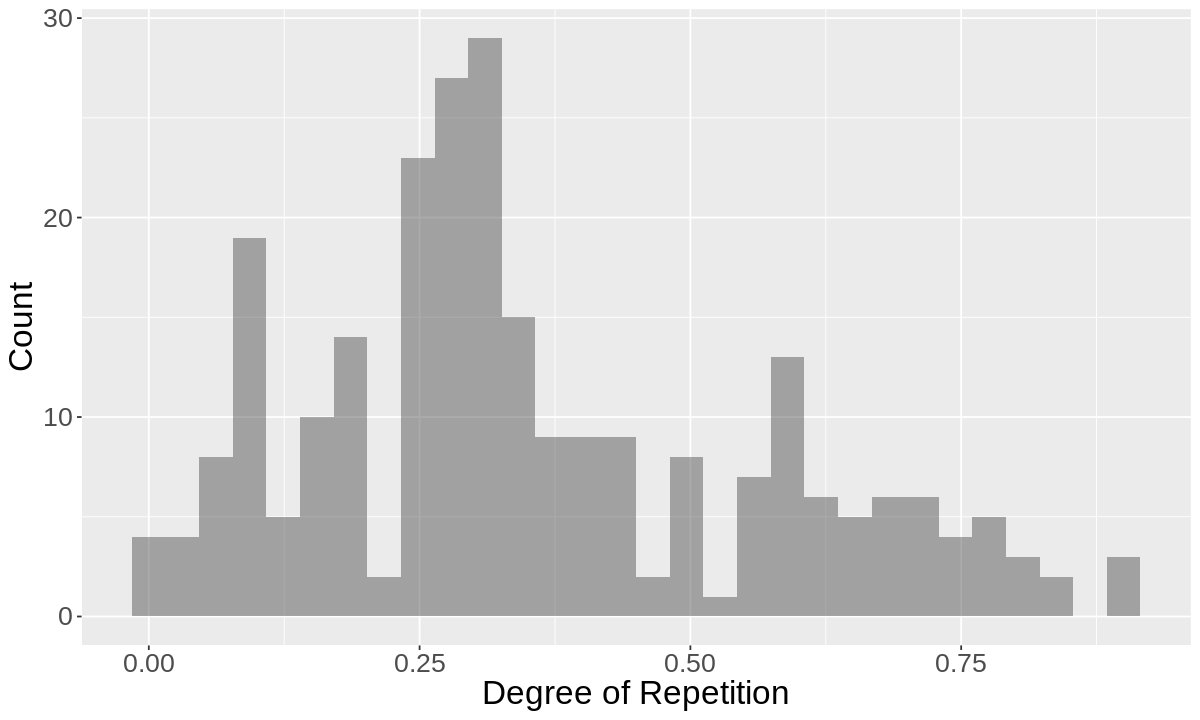

In [96]:
options(repr.plot.width = 10, repr.plot.height = 6)
STG_hist <- ggplot(knowledge, aes(x = STG)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    labs(x = "Degree of Study Time", 
    y = "Count") +
  theme(text = element_text(size = 20))

STG_hist

options(repr.plot.width = 10, repr.plot.height = 6)
SCG_hist <- ggplot(knowledge, aes(x = SCG)) +
    geom_histogram(alpha = 0.5, position = "identity") +
    labs(x = "Degree of Repetition", 
    y = "Count") +
    theme(text = element_text(size = 20))

SCG_hist



Next, some plots were created to help visualize the data that is being explored.

First a bar graph of the number of observations from each knowledge level was created, to check if the data sufficiently represented each group. If there is too much descripancy between the quantity of each observation, then we may represent one group accurately while having an unreliable representation of the other, which could lead to skewed results.

In [21]:
processed_graph_data <- knowledge_data_df %>%
                        select(STG, SCG, UNS)

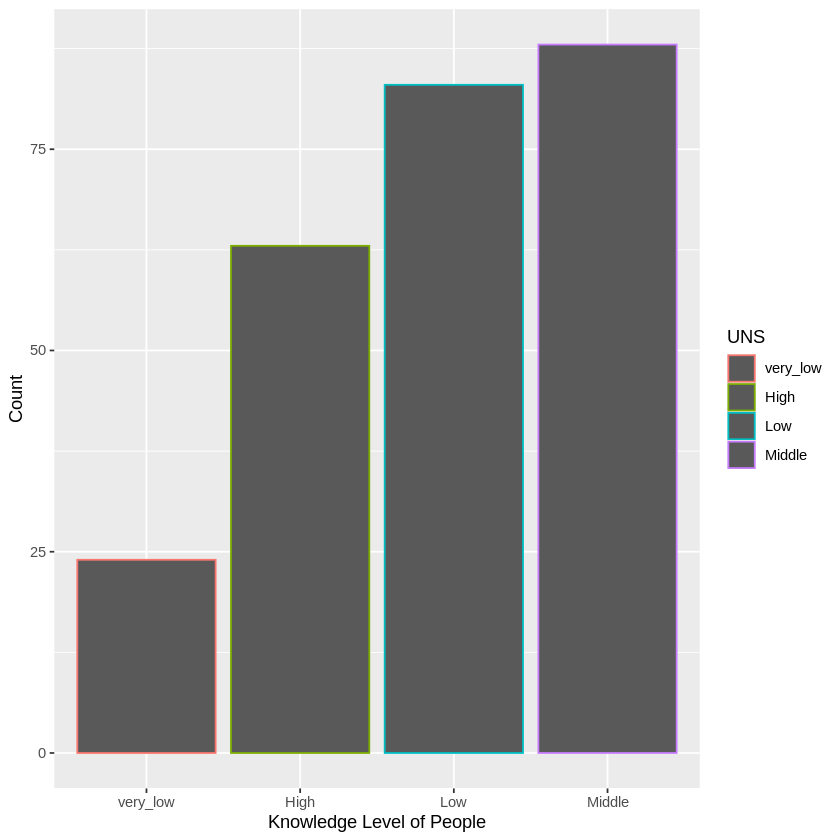

In [29]:
ggplot(processed_graph_data, aes(x = UNS, color = UNS)) +
geom_bar() +
labs(x = "Knowledge Level of People", y = "Count")